In [1]:
################################################################
### Network settings.
################################################################
NETWORK_INPUT_DIMENSIONS = (256, 256, 3)
NETWORK_OUTPUT_DIMENSIONS = (256, 256, 5)
BATCH_SIZE = 4
################################################################
### Dataset folder path.
################################################################
dataset_path = 'drive/MyDrive/aivaTWO/Dataset'
################################################################
### Hyperparamters.
################################################################
LAMBDA = 130
LEARNING_RATE = 2e-4
BETA = 0.5
GENERATOR_SCALE_FACTOR = 0.5
DISCRIMINATOR_SCALE_FACTOR = 0.5
################################################################
### Augmentation settings.
################################################################
MIRROR_PROBABILITY = 0.5
MAX_PADDING = 25
MIN_ROTATION_ANGLE = -180
MAX_ROTATION_ANGLE = 180

# **Setup** project.

> **TODO** [add description].



In [ ]:
################################################################
### Graphics card information.  
################################################################
!nvidia-smi

## **Import** dependencies.

In [3]:
#@title Connect with $google$ drive!
################################################################
### Connect runtime with google drive.
################################################################
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [4]:
################################################################
### Tensorflow import.
################################################################
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
import tensorflow as tf

In [5]:
################################################################
### General imports.
################################################################
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime
from tqdm import tqdm
from glob import glob
from IPython.display import HTML
from IPython import display as monitor
from zipfile import ZipFile

In [6]:
################################################################
### Create folder.
################################################################
def create_folder(path):
  try:
    os.mkdir(path)
    return True
  except OSError:
    return False
  else:
    return False

In [7]:
################################################################
### Progress bar.
################################################################
def progress(value, max=100,title=''):
  return HTML("""
        <label>{title}</label>
        <br>
        <progress
            value='{value}'
            max='{max}',
            style='width: 90%'>
            {value}
        </progress>
  """.format(value=value, max=max,title=title))

## **Define** dataset structure.

In [ ]:
################################################################
### Unpack dataset files.
################################################################
unpacked_dataset_path = 'samples'
create_folder(unpacked_dataset_path)
dataset_files = glob(f'{dataset_path}/*.zip')
for dataset_file in tqdm(dataset_files):
  with ZipFile(dataset_file, 'r') as zip_file:
    zip_file.extractall(unpacked_dataset_path)

In [10]:
def show_sample(image, mask, depth):
  ################################################################
  ### TODO.
  ################################################################
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 3))
  axes[0].imshow(image)
  axes[1].imshow(mask)
  axes[2].imshow(depth, cmap='gray')
  axes[0].set_title('Image')
  axes[1].set_title('Mask')
  axes[2].set_title('Depth')
  fig.show()

In [11]:
def random(minimum=0, maximum=1, data_type=tf.float32):
  ################################################################
  ### TODO.
  ################################################################
  return tf.random.uniform(shape=[], minval=minimum, maxval=maximum, dtype=data_type)

def chance(percentage=0.5):
  ################################################################
  ### TODO.
  ################################################################
  if random() < percentage:
    return True
  return False

def mirror(image, mask, depth, percentage=0.5):
  ################################################################
  ### TODO.
  ################################################################
  if chance(percentage):
    return image, mask, depth
  else:
    depth = cv2.flip(depth, 1) 
    depth = np.expand_dims(depth, axis=-1)
    return cv2.flip(image, 1),  cv2.flip(mask, 1), depth

def find_bounding_box(mask):
  ################################################################
  ### TODO.
  ################################################################
  contours, _ = cv2.findContours(mask[:, :, 3], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contour = max(contours, key=cv2.contourArea)
  return cv2.boundingRect(contour)

def crop_mask(image, mask, depth, max_padding):
  ################################################################
  ### TODO.
  ################################################################
  x, y, w, h = find_bounding_box(mask)
  random_padding = np.random.randint(-max_padding, max_padding+1, size=4)
  x -= random_padding[0]
  y -= random_padding[1]
  w += random_padding[2] + random_padding[0]
  h += random_padding[3] + random_padding[1]
  x = max(0, x)
  y = max(0, y)
  w = min(w, image.shape[1]-x)
  h = min(h, image.shape[0]-y)
  return image[y:y+h, x:x+w], mask[y:y+h, x:x+w], depth[y:y+h, x:x+w]

def rotate(image, mask, depth, min_angle, max_angle):
  ################################################################
  ### TODO.
  ################################################################
  angle = np.random.uniform(min_angle, max_angle)
  height, width = image.shape[:2]
  center = (width/2, height/2)
  M = cv2.getRotationMatrix2D(center, angle, 1)
  abs_cos = abs(M[0, 0])
  abs_sin = abs(M[0, 1])
  new_width = int(height * abs_sin + width * abs_cos)
  new_height = int(height * abs_cos + width * abs_sin)
  M[0, 2] += (new_width - width) / 2
  M[1, 2] += (new_height - height) / 2
  return cv2.warpAffine(image, M, (new_width, new_height), borderMode=cv2.BORDER_REPLICATE), cv2.warpAffine(mask, M, (new_width, new_height)), cv2.warpAffine(depth, M, (new_width, new_height))

def augment(image, mask, depth):
  ################################################################
  ### TODO.
  ################################################################
  image, mask, depth = rotate(image, mask, depth, MIN_ROTATION_ANGLE, MAX_ROTATION_ANGLE)
  image, mask, depth = mirror(image, mask, depth, MIRROR_PROBABILITY)
  image, mask, depth = crop_mask(image, mask, depth, MAX_PADDING)
  return image, mask, depth

In [12]:
#@title Tensorflow **dataset** functions.
def normalize_image(image):
  ################################################################
  ### TODO.
  ################################################################
  image = image.astype(np.float32)
  image = image / 255.0
  return image

def normalize_mask(mask):
  ################################################################
  ### TODO.
  ################################################################
  mask = mask.astype(np.float32)
  mask = mask / 255.0
  return mask

def normalize_depth(depth):
  ################################################################
  ### TODO.
  ################################################################
  depth = depth.astype(np.float32)
  depth = depth / depth.max()
  return depth

def clip_depth(alpha_mask, depth):
  ################################################################
  ### TODO.
  ################################################################
  max_value = depth[alpha_mask > 0].max()
  min_value = depth[alpha_mask > 0].min()
  depth = depth.astype(np.float32)
  depth[alpha_mask > 0]  -= min_value
  depth[alpha_mask > 0]  /= (max_value - min_value)
  depth *= 255
  depth = depth.astype('uint8')
  return depth

def load_image(path):
  ################################################################
  ### TODO.
  ################################################################
  image = cv2.imread(os.path.join(path, 'image.png'), cv2.IMREAD_COLOR)
  if image is None:
    image = cv2.imread(os.path.join(path, 'image.jpg'), cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

def load_mask(path):
  ################################################################
  ### TODO.
  ################################################################
  mask = cv2.imread(os.path.join(path, 'mask.png'), cv2.IMREAD_UNCHANGED)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGRA2RGBA)
  mask[mask[:, :, 3] == 0] = 0
  return mask

def load_depth(path):
  ################################################################
  ### TODO.
  ################################################################
  depth = cv2.imread(os.path.join(path, 'depth.png'), cv2.IMREAD_UNCHANGED)
  alpha_mask = depth[:, :, 3].copy()
  depth[alpha_mask == 0] = 0
  depth = cv2.cvtColor(depth, cv2.COLOR_BGRA2GRAY)
  depth = clip_depth(alpha_mask, depth)
  depth = np.expand_dims(depth, axis=-1)
  return depth

def resize(data, expand_dims=False):
  ################################################################
  ### TODO.
  ################################################################
  if not expand_dims:
    return cv2.resize(data, NETWORK_INPUT_DIMENSIONS[:2], interpolation=cv2.INTER_AREA)
  data = cv2.resize(data, NETWORK_INPUT_DIMENSIONS[:2], interpolation=cv2.INTER_AREA)
  data = np.expand_dims(data, axis=-1)
  return data

def decode(samples_path):
  ################################################################
  ### TODO.
  ################################################################
  path = samples_path.decode()
  image = load_image(path)
  mask = load_mask(path)
  depth = load_depth(path)
  ################################################################
  ### TODO.
  ################################################################
  image, mask, depth = augment(image, mask, depth)
  depth = clip_depth(mask[:, :, 3], depth)
  ################################################################
  ### TODO.
  ################################################################
  image = resize(image)
  mask = resize(mask)
  depth = resize(depth, expand_dims=True)
  ################################################################
  ### TODO.
  ################################################################
  image = normalize_image(image)
  mask = normalize_mask(mask)
  depth = normalize_depth(depth)
  ################################################################
  ### TODO.
  ################################################################
  depth_mask = np.zeros(NETWORK_OUTPUT_DIMENSIONS, dtype=np.float32)
  depth_mask[:, :, :4] = mask
  depth_mask[:, :, 4:] = depth
  return image, depth_mask

def preprocess(samples_paths):
  ################################################################
  ### TODO.
  ################################################################
  image, mask = tf.numpy_function(decode, [samples_paths], [tf.float32, tf.float32])
  image.set_shape(NETWORK_INPUT_DIMENSIONS)
  mask.set_shape(NETWORK_OUTPUT_DIMENSIONS)
  return image, mask

def build_tensorflow_dataset(samples_data, prefetch=3, batch_size=20):
  ################################################################
  ### TODO.
  ################################################################
  dataset = tf.data.Dataset.from_tensor_slices((samples_data))
  dataset = dataset.shuffle(buffer_size=len(samples_data)) 
  dataset = dataset.map(preprocess)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(prefetch)
  return dataset

In [13]:
################################################################
### Build tensorflow dataset.
################################################################
samples = glob(f'{unpacked_dataset_path}/*')
tf_dataset = build_tensorflow_dataset(samples, batch_size=BATCH_SIZE)

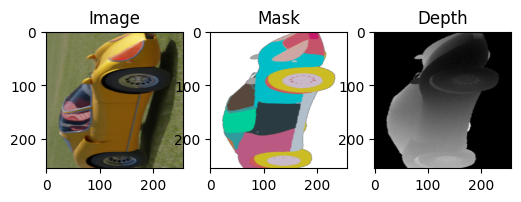

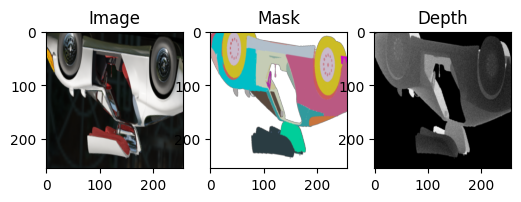

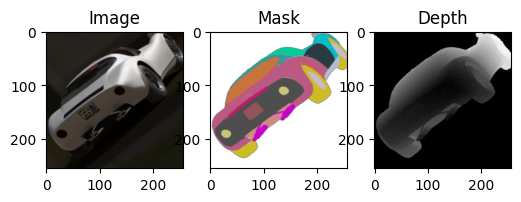

In [16]:
#@title **Show** $sample$ batch!
for images, masks in tf_dataset:
  for i in range(1, len(images)):
    show_sample(images[i - 1], masks[i - 1][:, :, :4], masks[i - 1][:, :, 4])
  break

## **Define** network structure.

In [ ]:
#@title Generator - **model** - functions.
def conv_block(inputs, num_filters, batch_norm=True):
  ################################################################
  ### TODO.
  ################################################################
  x = Conv2D(num_filters, 3, padding='same')(inputs)
  if batch_norm:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(num_filters, 3, padding='same')(x)
  if batch_norm:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

def encoder_block(inputs, num_filters):
  ################################################################
  ### TODO.
  ################################################################
  x = conv_block(inputs, num_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p

def decoder_block(inputs, skip_features, num_filters):
  ################################################################
  ### TODO.
  ################################################################
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def build_generator(input_shape, classes=1, factor=2):
  ################################################################
  ### TODO.
  ################################################################
  inputs = Input(input_shape)
  noise_input = GaussianNoise(0.01) (inputs)
  s1, p1 = encoder_block(noise_input, int(64*factor))
  s2, p2 = encoder_block(p1, int(64*factor))
  s3, p3 = encoder_block(p2, int(128*factor))
  s4, p4 = encoder_block(p3, int(256*factor))
  s5, p5 = encoder_block(p4, int(512*factor))
  s6, p6 = encoder_block(p5, int(512*factor))
  s7, p7 = encoder_block(p6, int(512*factor))
  s8, p8 = encoder_block(p7, int(512*factor))
  b1 = conv_block(p8, int(512*factor))
  d1 = decoder_block(b1, s8, int(512*factor))
  d2 = decoder_block(d1, s7, int(512*factor))
  d3 = decoder_block(d2, s6, int(512*factor))
  d4 = decoder_block(d3, s5, int(512*factor))
  d5 = decoder_block(d4, s4, int(256*factor))
  d6 = decoder_block(d5, s3, int(128*factor))
  d7 = decoder_block(d6, s2, int(64*factor))
  d8 = decoder_block(d7, s1, int(64*factor))
  outputs = Conv2D(classes, (1, 1), padding='same', activation='sigmoid')(d8)
  model = Model(inputs, outputs, name='Generator')
  return model

In [ ]:
#@title Discriminator - **model** - functions.
def build_discriminator(input_shape, target_shape, factor=1):
  ################################################################
  ### TODO.
  ################################################################
  input = Input(shape=input_shape)
  target = Input(shape=target_shape)
  x = Concatenate()([input, target])
  x = Conv2D(64*factor, 4, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False)(x)
  x = Conv2D(128*factor, 4, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  x = Conv2D(256*factor, 4, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  x = ZeroPadding2D()(x)
  x = Conv2D(512*factor, 4, strides=1, kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  x = ZeroPadding2D()(x)
  output = Conv2D(1, 4, strides=1, kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
  model = Model([input, target], output, name='Discriminator')
  return model

In [ ]:
#@title Model - **loss** - functions.
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  ################################################################
  ### TODO.
  ################################################################
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  ################################################################
  ### TODO.
  ################################################################
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

In [ ]:
################################################################
### TODO.
################################################################
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA)

In [ ]:
################################################################
### TODO.
################################################################
generator = build_generator(NETWORK_INPUT_DIMENSIONS, NETWORK_OUTPUT_DIMENSIONS[2], GENERATOR_SCALE_FACTOR)
generator.summary()
discriminator = build_discriminator(NETWORK_INPUT_DIMENSIONS, NETWORK_OUTPUT_DIMENSIONS, DISCRIMINATOR_SCALE_FACTOR)
discriminator.summary()

# **Training** process.

In [ ]:
checkpoint_dir = 'drive/MyDrive/aivaTWO' #@param {type:"string"}
max_to_keep = 2 #@param {type:"integer"}
log_dir = 'logs' #@param {type:"string"}
checkpoint_prefix = os.path.join(f'{checkpoint_dir}', 'Checkpoints')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_prefix, max_to_keep=max_to_keep)
checkpoint.restore(manager.latest_checkpoint)
summary_writer = tf.summary.create_file_writer(log_dir + '/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [ ]:
#@title **Training** functions!

def generate_preview(model, images, masks):
  ################################################################
  ### TODO.
  ################################################################
  prediction = model(images, training=True)
  plt.figure()
  figure, ax = plt.subplots(2, 3, figsize=(7, 7))
  ax[0, 0].imshow(np.squeeze(images[0]))
  ax[0, 1].imshow(masks[0][:, :, :4])
  ax[0, 2].imshow(masks[0][:, :, 4])
  ax[1, 0].imshow(np.squeeze(images[0]))
  ax[1, 1].imshow(prediction[0][:, :, :4])
  ax[1, 2].imshow(prediction[0][:, :, 4])
  plt.show()


@tf.function
def train_step(input_image, target, step):
  ################################################################
  ### TODO.
  ################################################################
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


def fit(train_ds, test_ds, steps, save_intervall=1000, preview_update_intervall=100):
  ################################################################
  ### TODO.
  ################################################################
  example_input, example_target = next(iter(test_ds.take(1)))
  progress_bar = display(progress(0, preview_update_intervall,''), display_id=True)
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if step % preview_update_intervall == 0:
      monitor.clear_output(wait=True)
      generate_preview(generator, example_input[:1], example_target[:1])
    train_step(input_image, target, step)
    progress_bar.update(progress(step % preview_update_intervall, preview_update_intervall, f'Progress {step % preview_update_intervall} / {preview_update_intervall} / {step}'))
    if (step + 1) % save_intervall == 0:
      manager.save()

In [ ]:
################################################################
### Train model.
################################################################
fit(tf_dataset, tf_dataset, steps=100000, save_intervall=1000)